# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['fuel', 'machine', 'others', 'part', 'price', 'service']
aspect_mapping = {'fuel': 0, 'machine': 1, 'others': 2, 'part': 3, 'price': 4, 'service': 5 }
label_mapping = {"negative": 0, "neutral": 1, 'positive': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/casa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/casa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/casa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [7]:
data.head()

,sentence,fuel,machine,others,part,price,service
0,Saya memakai Honda Jazz GK5 tahun 2014 ( perta...,neutral,neutral,positive,neutral,neutral,neutral
1,Avanza kenapa jadi boros bensin begini dah ah....,negative,neutral,neutral,neutral,neutral,neutral
2,"saran ku dan pengalaman ku , mending beli mobi...",positive,positive,neutral,neutral,neutral,neutral
3,Dari segi harga juga pajero lebih mahal 30 jut...,neutral,neutral,neutral,neutral,positive,neutral
4,Kalo menurut gw enak pajero si,neutral,neutral,positive,neutral,neutral,neutral


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['sentence'].values
y_train = train_data[train_labels].values
X_val = val_data['sentence'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(864,) (864, 6)
(216,) (216, 6)


# BUILD DATASET & DATALOADERS

In [10]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [11]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [12]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [13]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [14]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 25

In [16]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [18]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            ['fuel', 'machine', 'others', 'part', 'price', 'service']
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [19]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def monte_carlo_dropout_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.train()
    sentiment_model.to(device)
    sentiment_model.train()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neutral' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()
    aspect_uncertainties = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        
        for i in range(mc_passes):
            with torch.no_grad():
                outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
                probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
                batch_probs.append(probs)
                
        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)
        aspect_uncertainties.extend(uncertainties)

        for i in range(len(mean_probs)):
            aspect_outputs[batch['ori_indices'][i].item()] = [np.max(torch.sigmoid(outputs[i]).cpu().numpy())]
            
            for j in range(len(mean_probs[i])):
                if int(mean_probs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    aspect_outputs = {i: aspect_uncertainties[i] for i in range(len(aspect_uncertainties))}
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        for i in range(mc_passes):
            with torch.no_grad():
                outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                preds = torch.sigmoid(outputs.logits)

                for j in range(len(preds)):
                    ori_index = batch['ori_indices'][j].item()
                    if ori_index in sentiment_outputs.keys():
                        sentiment_outputs[ori_index].append(preds[j].cpu().numpy())
                    else:
                        sentiment_outputs[ori_index] = [preds[j].cpu().numpy()]

    accelerator.wait_for_everyone()
    for indices, probs in sentiment_outputs.items():
        sentiment_outputs[indices] = [[probs[i], probs[i+1], probs[i+2]] for i in range(int(len(probs) / 3))]
        
        variance = np.var(sentiment_outputs[indices], axis=1)
        mean_aspect_variance = np.mean(variance, axis=1)
        mean_data_variance = np.mean(mean_aspect_variance)
        
        sentiment_outputs[indices] = np.mean(np.mean(np.var(sentiment_outputs[indices], axis=0), axis=0), axis=0)

    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))

        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = (val + aspect_outputs[key]) / 2

        uncertainties = np.array(list(aspect_outputs.values()))
        sorted_unc = np.argsort(uncertainties)
        sorted_unc = sorted_unc[::-1]

        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
        
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i, init_size):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = f'casa-mc-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print("Init Size {}".format(init_size))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed,
            filename
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i,
            filename
        )
        notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed,
        filename
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

Init Size 1
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6716, Accuracy: 0.6763, F1 Micro: 0.7845, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.623, Accuracy: 0.724, F1 Micro: 0.8277, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5676, Accuracy: 0.7478, F1 Micro: 0.8485, F1 Macro: 0.8168
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5258, Accuracy: 0.776, F1 Micro: 0.8712, F1 Macro: 0.865
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4874, Accuracy: 0.7932, F1 Micro: 0.884, F1 Macro: 0.8824
Epoch 6/10, Train Loss: 0.453, Accuracy: 0.7902, F1 Micro: 0.8826, F1 Macro: 0.8811
Epoch 7/10, Train Loss: 0.4214, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 8/10, Train Loss: 0.4196, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 9/10, Train Loss: 0.3868, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Epoch 10/10, Train Loss: 0.3569, Accuracy: 0.7917, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6232, Accuracy: 0.7778, F1 Micro: 0.7778, F1 Macro: 0.4375
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4977, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3777, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2928, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2176, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1723, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1318, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1066, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6332, Accuracy: 0.744, F1 Micro: 0.8445, F1 Macro: 0.8084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5447, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Epoch 3/10, Train Loss: 0.494, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 4/10, Train Loss: 0.4655, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 5/10, Train Loss: 0.4584, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4491, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4385, Accuracy: 0.7954, F1 Micro: 0.8852, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3857, Accuracy: 0.8065, F1 Micro: 0.8908, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3372, Accuracy: 0.8185, F1 Micro: 0.8967, F1 Macro: 0.8957
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6267, Accuracy: 0.7595, F1 Micro: 0.7595, F1 Macro: 0.4783
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6756, Accuracy: 0.7595, F1 Micro: 0.7595, F1 Macro: 0.4783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5026, Accuracy: 0.7595, F1 Micro: 0.7595, F1 Macro: 0.4783
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4754, Accuracy: 0.8101, F1 Micro: 0.8101, F1 Macro: 0.699
Epoch 5/10, Train Loss: 0.3365, Accuracy: 0.7975, F1 Micro: 0.7975, F1 Macro: 0.7002
Epoch 6/10, Train Loss: 0.2778, Accuracy: 0.7975, F1 Micro: 0.7975, F1 Macro: 0.6865
Epoch 7/10, Train Loss: 0.2606, Accuracy: 0.7975, F1 Micro: 0.7975, F1 Macro: 0.7002
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1669, Accuracy: 0.8228, F1 Micro: 0.8228, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0797, Accuracy: 0.8228, F1 Micro: 0.8228, F1 Macro: 0.7657
Epoch 10/10, Train Loss: 0.0523, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6008, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4884, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4621, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4531, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4203, Accuracy: 0.8125, F1 Micro: 0.8935, F1 Macro: 0.8921
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3496, Accuracy: 0.8795, F1 Micro: 0.9277, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3018, Accuracy: 0.8996, F1 Micro: 0.9378, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2676, Accuracy: 0.9137, F1 Micro: 0.9468, F1 Macro: 0.9447
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6267, Accuracy: 0.6786, F1 Micro: 0.6786, F1 Macro: 0.4043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5218, Accuracy: 0.6786, F1 Micro: 0.6786, F1 Macro: 0.4043
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4386, Accuracy: 0.8527, F1 Micro: 0.8527, F1 Macro: 0.822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2399, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8819
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9196, F1 Micro: 0.9196, F1 Macro: 0.9079
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0566, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9193
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.9063
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.8616, F1 Micro: 0.8616, F1 Macro: 0.854
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9294
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5924, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5254, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5021, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.444, Accuracy: 0.8095, F1 Micro: 0.8923, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4052, Accuracy: 0.8862, F1 Micro: 0.9309, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3448, Accuracy: 0.9122, F1 Micro: 0.9464, F1 Macro: 0.9447
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2798, Accuracy: 0.9196, F1 Micro: 0.95, F1 Macro: 0.9477
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.228, Accuracy: 0.9338, F1 Micro: 0.9588, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5814, Accuracy: 0.6749, F1 Micro: 0.6749, F1 Macro: 0.4029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4616, Accuracy: 0.749, F1 Micro: 0.749, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2933, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8746
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9465, F1 Micro: 0.9465, F1 Macro: 0.9404
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.9058
Epoch 6/10, Train Loss: 0.0721, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.9056
Epoch 7/10, Train Loss: 0.1331, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9237
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9259, F1 Micro: 0.9259, F1 Macro: 0.9161
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9383, F1 Micro: 0.9383, F1 Macro: 0.9316
Epoch 10/10, Train Loss: 0.1091, Accuracy: 0.93, F1 Micro: 0.93, F1 Macro: 0.9233

Sentiment analysis accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5833, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5043, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4939, Accuracy: 0.7991, F1 Micro: 0.8871, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4233, Accuracy: 0.8668, F1 Micro: 0.9203, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3571, Accuracy: 0.91, F1 Micro: 0.9446, F1 Macro: 0.9421
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2849, Accuracy: 0.9308, F1 Micro: 0.957, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.23, Accuracy: 0.9375, F1 Micro: 0.9611, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1881, Accuracy: 0.9435, F1 Micro: 0.9647, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5721, Accuracy: 0.672, F1 Micro: 0.672, F1 Macro: 0.4019
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4369, Accuracy: 0.892, F1 Micro: 0.892, F1 Macro: 0.8786
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2196, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9249
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.924
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.9013
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1329, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9295
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9422
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9299
Epoch 9/10, Train Loss: 0.0744, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9369
Epoch 10/10, Train Loss: 0.0597, Accuracy: 0.928, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5769, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5231, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4583, Accuracy: 0.8371, F1 Micro: 0.906, F1 Macro: 0.9051
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3822, Accuracy: 0.8839, F1 Micro: 0.9285, F1 Macro: 0.9257
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.308, Accuracy: 0.9137, F1 Micro: 0.9462, F1 Macro: 0.9436
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2496, Accuracy: 0.9405, F1 Micro: 0.9629, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2001, Accuracy: 0.9464, F1 Micro: 0.9665, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1596, Accuracy: 0.9539, F1 Micro: 0.9709, F1 Macro: 0.9695
Epoch 9/10, Train Loss: 0.1258, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5901, Accuracy: 0.6719, F1 Micro: 0.6719, F1 Macro: 0.4019
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4304, Accuracy: 0.875, F1 Micro: 0.875, F1 Macro: 0.8503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2177, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.9067
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1208, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9426
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9258, F1 Micro: 0.9258, F1 Macro: 0.9192
Epoch 6/10, Train Loss: 0.1346, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9492, F1 Micro: 0.9492, F1 Macro: 0.9426
Epoch 8/10, Train Loss: 0.1446, Accuracy: 0.9453, F1 Micro: 0.9453, F1 Macro: 0.9397
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9315
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0582, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5933, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5217, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4693, Accuracy: 0.8542, F1 Micro: 0.915, F1 Macro: 0.9138
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3732, Accuracy: 0.8973, F1 Micro: 0.9361, F1 Macro: 0.9329
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3143, Accuracy: 0.9249, F1 Micro: 0.9535, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2435, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2041, Accuracy: 0.9494, F1 Micro: 0.9682, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1604, Accuracy: 0.9561, F1 Micro: 0.9723, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5287, Accuracy: 0.6729, F1 Micro: 0.6729, F1 Macro: 0.4022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3432, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9328
Epoch 4/10, Train Loss: 0.1369, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.9069
Epoch 5/10, Train Loss: 0.095, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9142
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9339
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9624, F1 Micro: 0.9624, F1 Macro: 0.9578
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9549, F1 Micro: 0.9549, F1 Macro: 0.9499
Epoch 10/10, Train Loss: 0.083, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5806, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5208, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4382, Accuracy: 0.8713, F1 Micro: 0.9222, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.353, Accuracy: 0.9159, F1 Micro: 0.9481, F1 Macro: 0.9465
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2685, Accuracy: 0.9464, F1 Micro: 0.9665, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2148, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1674, Accuracy: 0.9591, F1 Micro: 0.9743, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1341, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5827, Accuracy: 0.6729, F1 Micro: 0.6729, F1 Macro: 0.4601
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3052, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1905, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9248
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9339
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9339
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9375
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9474, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5652, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5009, Accuracy: 0.8289, F1 Micro: 0.9018, F1 Macro: 0.9009
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4149, Accuracy: 0.8832, F1 Micro: 0.9272, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3109, Accuracy: 0.9323, F1 Micro: 0.9575, F1 Macro: 0.9551
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2442, Accuracy: 0.9494, F1 Micro: 0.9682, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1912, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1571, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1178, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0914, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5411, Accuracy: 0.7041, F1 Micro: 0.7041, F1 Macro: 0.5102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2917, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.914
Epoch 3/10, Train Loss: 0.1844, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8948
Epoch 4/10, Train Loss: 0.1481, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8885
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9105
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9286
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.9326, F1 Micro: 0.9326, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0769, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9297
Epoch 9/10, Train Loss: 0.0932, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.899
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0852, Accuracy: 0.9551, F1 Micro: 0.9551, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5628, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4957, Accuracy: 0.8281, F1 Micro: 0.9012, F1 Macro: 0.8996
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4017, Accuracy: 0.8996, F1 Micro: 0.9377, F1 Macro: 0.9347
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3043, Accuracy: 0.9405, F1 Micro: 0.963, F1 Macro: 0.9614
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2423, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1783, Accuracy: 0.9606, F1 Micro: 0.9751, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1433, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1113, Accuracy: 0.971, F1 Micro: 0.9816, F1 Macro: 0.9803
Epoch 9/10, Train Loss: 0.0888, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5466, Accuracy: 0.679, F1 Micro: 0.679, F1 Macro: 0.4044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3085, Accuracy: 0.941, F1 Micro: 0.941, F1 Macro: 0.9327
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9259
Epoch 4/10, Train Loss: 0.1247, Accuracy: 0.8708, F1 Micro: 0.8708, F1 Macro: 0.8632
Epoch 5/10, Train Loss: 0.1586, Accuracy: 0.8745, F1 Micro: 0.8745, F1 Macro: 0.8669
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9309
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9299, F1 Micro: 0.9299, F1 Macro: 0.9232
Epoch 8/10, Train Loss: 0.1278, Accuracy: 0.9299, F1 Micro: 0.9299, F1 Macro: 0.9216
Epoch 9/10, Train Loss: 0.0955, Accuracy: 0.9299, F1 Micro: 0.9299, F1 Macro: 0.922
Epoch 10/10, Train Loss: 0.0639, Accuracy: 0.9299, F1 Micro: 0.9299, F1 Macro: 0.9216

Sentiment analysis accuracy: 0.941, F1 Micro: 0.941, F1 Macro: 0.9327
              pre

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5641, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4966, Accuracy: 0.8095, F1 Micro: 0.8923, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3999, Accuracy: 0.9077, F1 Micro: 0.9432, F1 Macro: 0.9408
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3151, Accuracy: 0.939, F1 Micro: 0.9623, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2379, Accuracy: 0.9583, F1 Micro: 0.9741, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1943, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1443, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.977
Epoch 8/10, Train Loss: 0.1227, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.097, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5061, Accuracy: 0.7096, F1 Micro: 0.7096, F1 Macro: 0.5044
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3175, Accuracy: 0.9301, F1 Micro: 0.9301, F1 Macro: 0.92
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.9157
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9072
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9077
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9338, F1 Micro: 0.9338, F1 Macro: 0.9265
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1211, Accuracy: 0.9375, F1 Micro: 0.9375, F1 Macro: 0.9304
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9379
Epoch 9/10, Train Loss: 0.091, Accuracy: 0.9265, F1 Micro: 0.9265, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0598, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5638, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.492, Accuracy: 0.8452, F1 Micro: 0.9105, F1 Macro: 0.9093
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3791, Accuracy: 0.9226, F1 Micro: 0.9527, F1 Macro: 0.9517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2965, Accuracy: 0.9464, F1 Micro: 0.9666, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2167, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1615, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.1418, Accuracy: 0.9583, F1 Micro: 0.9736, F1 Macro: 0.9717
Epoch 8/10, Train Loss: 0.1053, Accuracy: 0.9628, F1 Micro: 0.9765, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0857, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9783
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5537, Accuracy: 0.6803, F1 Micro: 0.6803, F1 Macro: 0.4049
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3022, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9365
Epoch 3/10, Train Loss: 0.1547, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.926
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9412
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9336
Epoch 6/10, Train Loss: 0.1258, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9216
Epoch 7/10, Train Loss: 0.1329, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.93
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9339
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.932
Epoch 10/10, Train Loss: 0.0678, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9104

Sentiment analysis accuracy: 0.948, F1 Micro: 0.948, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.555, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4736, Accuracy: 0.875, F1 Micro: 0.9261, F1 Macro: 0.926
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3638, Accuracy: 0.9211, F1 Micro: 0.9513, F1 Macro: 0.9498
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2637, Accuracy: 0.9524, F1 Micro: 0.9704, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1961, Accuracy: 0.9539, F1 Micro: 0.9711, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1541, Accuracy: 0.9643, F1 Micro: 0.9776, F1 Macro: 0.9765
Epoch 7/10, Train Loss: 0.1232, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 9/10, Train Loss: 0.0769, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5197, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2592, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9298
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9353
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9336
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1298, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9389
Epoch 8/10, Train Loss: 0.0991, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9111
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.9103
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5576, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4595, Accuracy: 0.8765, F1 Micro: 0.9267, F1 Macro: 0.9263
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3518, Accuracy: 0.9249, F1 Micro: 0.9532, F1 Macro: 0.9505
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.259, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1959, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1453, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1155, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9809
Epoch 8/10, Train Loss: 0.0943, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4973, Accuracy: 0.8798, F1 Micro: 0.8798, F1 Macro: 0.8706
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.928
Epoch 3/10, Train Loss: 0.1671, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9048
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9201
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9106
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1186, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9277
Epoch 7/10, Train Loss: 0.1208, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9133
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9192
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9203
Epoch 10/10, Train Loss: 0.0593, Accuracy: 0.9302, F1 Micro: 0.9302, F1 Macro: 0.9243

Sentiment analysis accuracy: 0.9341, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5588, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4569, Accuracy: 0.8802, F1 Micro: 0.9277, F1 Macro: 0.9266
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3398, Accuracy: 0.9293, F1 Micro: 0.9562, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2386, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1739, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1365, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0693, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5143, Accuracy: 0.8605, F1 Micro: 0.8605, F1 Macro: 0.8411
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2449, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1752, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.9071
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1295, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9306
Epoch 6/10, Train Loss: 0.1343, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9277
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro: 0.9174
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1141, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9275
Epoch 9/10, Train Loss: 0.1147, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5415, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4244, Accuracy: 0.8876, F1 Micro: 0.9316, F1 Macro: 0.9302
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3019, Accuracy: 0.9382, F1 Micro: 0.9617, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2205, Accuracy: 0.9561, F1 Micro: 0.9725, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.162, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.9791
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.978
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9739
Higher F1 achieved, saving 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5061, Accuracy: 0.8727, F1 Micro: 0.8727, F1 Macro: 0.8604
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2869, Accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.937
Epoch 3/10, Train Loss: 0.1839, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.9051
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9251, F1 Micro: 0.9251, F1 Macro: 0.9179
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.9286
Epoch 6/10, Train Loss: 0.1111, Accuracy: 0.9401, F1 Micro: 0.9401, F1 Macro: 0.931
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.929
Epoch 8/10, Train Loss: 0.099, Accuracy: 0.9363, F1 Micro: 0.9363, F1 Macro: 0.929
Epoch 9/10, Train Loss: 0.0879, Accuracy: 0.9288, F1 Micro: 0.9288, F1 Macro: 0.921
Epoch 10/10, Train Loss: 0.0766, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.9004

Sentiment analysis accuracy: 0.9438, F1 Micro: 0.9438, F1 Macro: 0.937
              pre

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5475, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4315, Accuracy: 0.8899, F1 Micro: 0.9327, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3084, Accuracy: 0.9449, F1 Micro: 0.9658, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2195, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9783
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.9613, F1 Micro: 0.9756, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5425, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9277
Epoch 3/10, Train Loss: 0.1428, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9035
Epoch 4/10, Train Loss: 0.1351, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.9072
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1139, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9277
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9237
Epoch 7/10, Train Loss: 0.1267, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.905
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9197
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9237
Epoch 10/10, Train Loss: 0.0515, Accuracy: 0.931, F1 Micro: 0.931, F1 Macro: 0.9241

Sentiment analysis accuracy: 0.9349, F1 Micro: 0.9349, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5426, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4225, Accuracy: 0.9122, F1 Micro: 0.9463, F1 Macro: 0.945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2889, Accuracy: 0.9427, F1 Micro: 0.9642, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2055, Accuracy: 0.9576, F1 Micro: 0.9735, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1162, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9809
Epoch 7/10, Train Loss: 0.0929, Accuracy: 0.9673, F1 Micro: 0.9793, F1 Macro: 0.9779
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9788
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5334, Accuracy: 0.8779, F1 Micro: 0.8779, F1 Macro: 0.857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2895, Accuracy: 0.8969, F1 Micro: 0.8969, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9367
Epoch 4/10, Train Loss: 0.1182, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9427, F1 Micro: 0.9427, F1 Macro: 0.9364
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9271
Epoch 7/10, Train Loss: 0.1329, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.921
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9206
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9198
Epoch 10/10, Train Loss: 0.0612, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9127

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5369, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4092, Accuracy: 0.9137, F1 Micro: 0.9466, F1 Macro: 0.9443
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2878, Accuracy: 0.9501, F1 Micro: 0.969, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1931, Accuracy: 0.9628, F1 Micro: 0.9767, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9801
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9741
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.059, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9785
Epoch 10/10, Train Loss: 0.0527, Accuracy: 0.9628, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5549, Accuracy: 0.7419, F1 Micro: 0.7419, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2609, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.9362
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9261
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1094, Accuracy: 0.9435, F1 Micro: 0.9435, F1 Macro: 0.938
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9516, F1 Micro: 0.9516, F1 Macro: 0.9466
Epoch 7/10, Train Loss: 0.1141, Accuracy: 0.9395, F1 Micro: 0.9395, F1 Macro: 0.9341
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.9215
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9315, F1 Micro: 0.9315, F1 Macro: 0.9197
Epoch 10/10, Train Loss: 0.0659, Accuracy: 0.9435, F1 Micro: 0.9435, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5397, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4067, Accuracy: 0.9115, F1 Micro: 0.9454, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2822, Accuracy: 0.9494, F1 Micro: 0.9685, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1923, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9777
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9791
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5073, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.245, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9343
Epoch 3/10, Train Loss: 0.1546, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9288
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9312
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9437
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.935
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9357
Epoch 8/10, Train Loss: 0.1002, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9405
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.9533, F1 Micro: 0.9533, F1 Macro: 0.9469
Epoch 10/10, Train Loss: 0.054, Accuracy: 0.9494, F1 Micro: 0.9494, F1 Macro: 0.9437

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.537, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3986, Accuracy: 0.9182, F1 Micro: 0.9493, F1 Macro: 0.9462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2694, Accuracy: 0.9494, F1 Micro: 0.9683, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 7/10, Train Loss: 0.0837, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9764
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4922, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.8912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2008, Accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9449
Epoch 3/10, Train Loss: 0.1601, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9271
Epoch 4/10, Train Loss: 0.1289, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9266
Epoch 5/10, Train Loss: 0.1145, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.918
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9319
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9239
Epoch 8/10, Train Loss: 0.0736, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9194
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9243
Epoch 10/10, Train Loss: 0.0541, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8985

Sentiment analysis accuracy: 0.9509, F1 Micro: 0.9509, F1 Macro: 0.9449
           

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5261, Accuracy: 0.8006, F1 Micro: 0.8879, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.381, Accuracy: 0.9271, F1 Micro: 0.9547, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2493, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9621, F1 Micro: 0.9762, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9795
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9782
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5233, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8757
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2445, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9248
Epoch 3/10, Train Loss: 0.1624, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8894
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9213
Epoch 5/10, Train Loss: 0.1033, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9156
Epoch 6/10, Train Loss: 0.083, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9138
Epoch 7/10, Train Loss: 0.0722, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.9013
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9317
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9134
Epoch 10/10, Train Loss: 0.0708, Accuracy: 0.9323, F1 Micro: 0.9323, F1 Macro: 0.9217

Sentiment analysis accuracy: 0.9398, F1 Micro: 0.9398

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5303, Accuracy: 0.7917, F1 Micro: 0.8834, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3836, Accuracy: 0.9174, F1 Micro: 0.9485, F1 Macro: 0.9451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2475, Accuracy: 0.9524, F1 Micro: 0.9705, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1685, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0837, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9802
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5058, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9208
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.9125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1443, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9359
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9322
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9425, F1 Micro: 0.9425, F1 Macro: 0.9355
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.9387, F1 Micro: 0.9387, F1 Macro: 0.9322
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9349, F1 Micro: 0.9349, F1 Macro: 0.9277
Epoch 9/10, Train Loss: 0.0773, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.9161
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0726, Accuracy: 0.9464, F1 Micro: 0.9464, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5124, Accuracy: 0.7961, F1 Micro: 0.8856, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3614, Accuracy: 0.9323, F1 Micro: 0.9578, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2369, Accuracy: 0.9494, F1 Micro: 0.9688, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.98
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4949, Accuracy: 0.8953, F1 Micro: 0.8953, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.9341, F1 Micro: 0.9341, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.94
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.9457, F1 Micro: 0.9457, F1 Macro: 0.9378
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.908
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9419, F1 Micro: 0.9419, F1 Macro: 0.9351
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9159
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.938, F1 Micro: 0.938, F1 Macro: 0.9302
Epoch 10/10, Train Loss: 0.0575, Accuracy: 0.9264, F1 Micro: 0.9264, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5188, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3655, Accuracy: 0.9338, F1 Micro: 0.9587, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2221, Accuracy: 0.9568, F1 Micro: 0.973, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.965, F1 Micro: 0.978, F1 Macro: 0.9767
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9695, F1 Micro: 0.9809, F1 Macro: 0.9798
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9808
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.9801
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5047, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2306, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9158
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1843, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9213
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9528, F1 Micro: 0.9528, F1 Macro: 0.9484
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.9488, F1 Micro: 0.9488, F1 Macro: 0.9439
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.937, F1 Micro: 0.937, F1 Macro: 0.9318
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9277
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.92
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0678, Accuracy: 0.

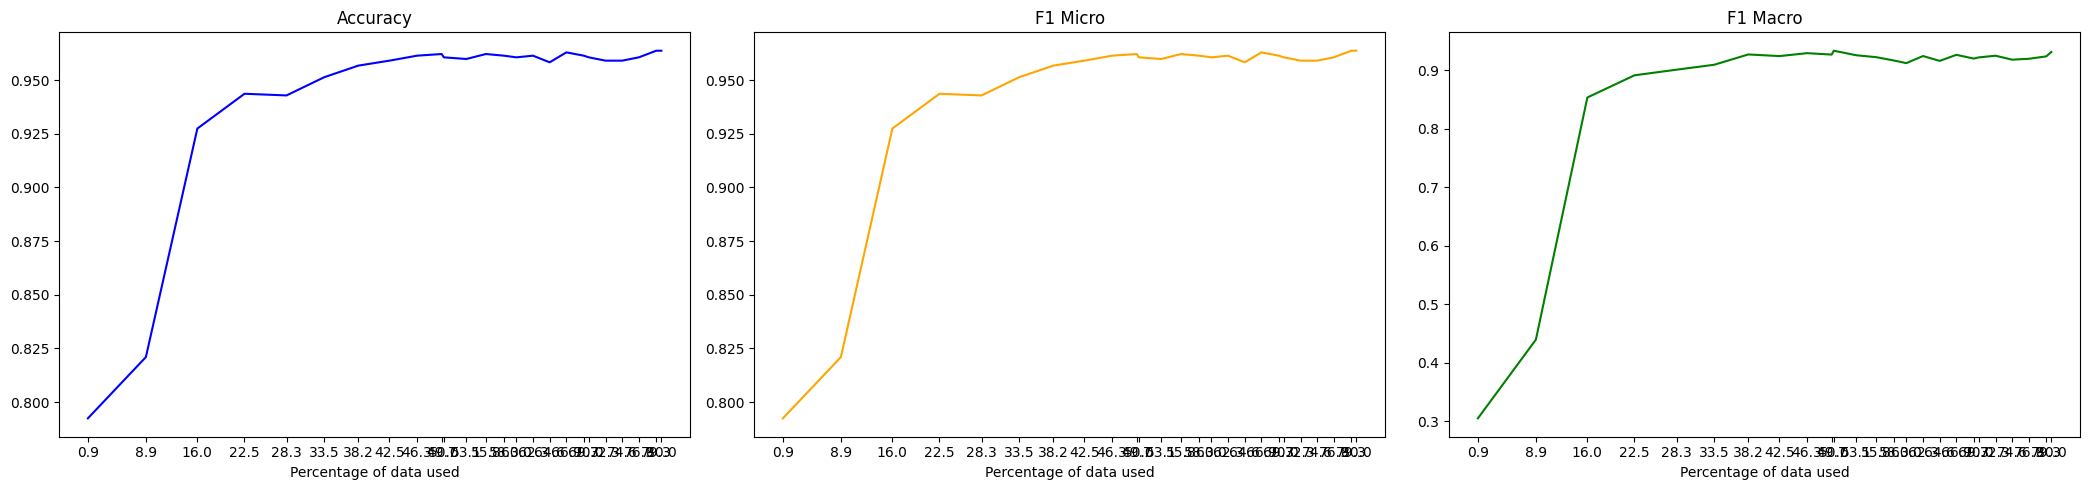

In [22]:
initial_train_size = int(0.01 * total_data)
active_learning(81, 0, 1)

Init Size 10
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6328, Accuracy: 0.7493, F1 Micro: 0.85, F1 Macro: 0.8204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5334, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4951, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4625, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Epoch 5/10, Train Loss: 0.4453, Accuracy: 0.7894, F1 Micro: 0.8822, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4135, Accuracy: 0.7999, F1 Micro: 0.8872, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3939, Accuracy: 0.8177, F1 Micro: 0.8959, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3601, Accuracy: 0.846, F1 Micro: 0.91, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3088, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.647, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.4466
Epoch 2/10, Train Loss: 0.5679, Accuracy: 0.7374, F1 Micro: 0.7374, F1 Macro: 0.4244
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5035, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.4466
Epoch 4/10, Train Loss: 0.4771, Accuracy: 0.7318, F1 Micro: 0.7318, F1 Macro: 0.5318
Epoch 5/10, Train Loss: 0.4109, Accuracy: 0.7263, F1 Micro: 0.7263, F1 Macro: 0.622
Epoch 6/10, Train Loss: 0.3137, Accuracy: 0.7263, F1 Micro: 0.7263, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.267, Accuracy: 0.743, F1 Micro: 0.743, F1 Macro: 0.704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1947, Accuracy: 0.7821, F1 Micro: 0.7821, F1 Macro: 0.7454
Epoch 9/10, Train Loss: 0.1264, Accuracy: 0.7765, F1 Micro: 0.7765, F1 Macro: 0.7258
Epoch 10/10, Train Loss: 0.0975, Accuracy: 0.7542, F1 Micro: 0.7542, F1 Macro: 0.7018

Sentiment analysis accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6221, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5373, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.515, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4673, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4438, Accuracy: 0.8028, F1 Micro: 0.889, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3931, Accuracy: 0.8408, F1 Micro: 0.908, F1 Macro: 0.9068
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3512, Accuracy: 0.8996, F1 Micro: 0.9391, F1 Macro: 0.9377
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3103, Accuracy: 0.9144, F1 Micro: 0.9476, F1 Macro: 0.9458
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5673, Accuracy: 0.6844, F1 Micro: 0.6844, F1 Macro: 0.4063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.514, Accuracy: 0.6844, F1 Micro: 0.6844, F1 Macro: 0.4063
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4373, Accuracy: 0.76, F1 Micro: 0.76, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2735, Accuracy: 0.8711, F1 Micro: 0.8711, F1 Macro: 0.8491
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1736, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.8737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0546, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8821
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.8622, F1 Micro: 0.8622, F1 Macro: 0.8316
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.8489, F1 Micro: 0.8489, F1 Macro: 0.83
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6081, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.536, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.511, Accuracy: 0.7954, F1 Micro: 0.8853, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.487, Accuracy: 0.808, F1 Micro: 0.8916, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4128, Accuracy: 0.8839, F1 Micro: 0.9305, F1 Macro: 0.9299
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3532, Accuracy: 0.9077, F1 Micro: 0.9434, F1 Macro: 0.9418
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2957, Accuracy: 0.9263, F1 Micro: 0.9544, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2344, Accuracy: 0.9375, F1 Micro: 0.9609, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5886, Accuracy: 0.695, F1 Micro: 0.695, F1 Macro: 0.41
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5257, Accuracy: 0.6988, F1 Micro: 0.6988, F1 Macro: 0.4349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3899, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2063, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8808
Epoch 5/10, Train Loss: 0.1619, Accuracy: 0.8764, F1 Micro: 0.8764, F1 Macro: 0.8658
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1271, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9005
Epoch 7/10, Train Loss: 0.1516, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1229, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.9025
Epoch 9/10, Train Loss: 0.1031, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8756
Epoch 10/10, Train Loss: 0.078, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5944, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5457, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5208, Accuracy: 0.8073, F1 Micro: 0.8912, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.454, Accuracy: 0.8638, F1 Micro: 0.9194, F1 Macro: 0.9187
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3773, Accuracy: 0.8981, F1 Micro: 0.9375, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.312, Accuracy: 0.9241, F1 Micro: 0.9531, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2376, Accuracy: 0.9457, F1 Micro: 0.9663, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2081, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9691
Epoch 9/10, Train Loss: 0.164, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5072, Accuracy: 0.668, F1 Micro: 0.668, F1 Macro: 0.4005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4044, Accuracy: 0.834, F1 Micro: 0.834, F1 Macro: 0.787
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2447, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9312, F1 Micro: 0.9312, F1 Macro: 0.9236
Epoch 5/10, Train Loss: 0.1729, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8962
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.9039
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1838, Accuracy: 0.9352, F1 Micro: 0.9352, F1 Macro: 0.929
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1079, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9401
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0896, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9401
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5847, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5211, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4836, Accuracy: 0.8423, F1 Micro: 0.9084, F1 Macro: 0.9076
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4051, Accuracy: 0.8884, F1 Micro: 0.9317, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3228, Accuracy: 0.9167, F1 Micro: 0.9478, F1 Macro: 0.9445
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2671, Accuracy: 0.9479, F1 Micro: 0.9677, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2227, Accuracy: 0.9524, F1 Micro: 0.9702, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1622, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.1396, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5046, Accuracy: 0.6846, F1 Micro: 0.6846, F1 Macro: 0.4064
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3908, Accuracy: 0.8962, F1 Micro: 0.8962, F1 Macro: 0.872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2366, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9264
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.906
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1293, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9264
Epoch 6/10, Train Loss: 0.1666, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.903
Epoch 7/10, Train Loss: 0.0825, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.898
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9423, F1 Micro: 0.9423, F1 Macro: 0.9343
Epoch 9/10, Train Loss: 0.1048, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9305
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.1011, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5764, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5127, Accuracy: 0.7924, F1 Micro: 0.8838, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4473, Accuracy: 0.8787, F1 Micro: 0.9267, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3504, Accuracy: 0.9174, F1 Micro: 0.9489, F1 Macro: 0.947
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2864, Accuracy: 0.9382, F1 Micro: 0.9616, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2166, Accuracy: 0.9546, F1 Micro: 0.9715, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1701, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.128, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Epoch 9/10, Train Loss: 0.1083, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5437, Accuracy: 0.6828, F1 Micro: 0.6828, F1 Macro: 0.4058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3345, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8784
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2397, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9323
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9279
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9168
Epoch 6/10, Train Loss: 0.133, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.9478, F1 Micro: 0.9478, F1 Macro: 0.9401
Epoch 8/10, Train Loss: 0.1319, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9261
Epoch 9/10, Train Loss: 0.1133, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9279
Epoch 10/10, Train Loss: 0.0902, Accuracy: 0.9328, F1 Micro: 0.9328, F1 Macro: 0.9251

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5817, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5154, Accuracy: 0.8043, F1 Micro: 0.8897, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4279, Accuracy: 0.8802, F1 Micro: 0.9279, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3403, Accuracy: 0.9167, F1 Micro: 0.9486, F1 Macro: 0.9475
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2714, Accuracy: 0.9524, F1 Micro: 0.9703, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.216, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.165, Accuracy: 0.9591, F1 Micro: 0.9742, F1 Macro: 0.9729
Epoch 8/10, Train Loss: 0.1332, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9739
Epoch 9/10, Train Loss: 0.1081, Accuracy: 0.9606, F1 Micro: 0.9753, F1 Macro: 0.974
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5387, Accuracy: 0.69, F1 Micro: 0.69, F1 Macro: 0.4083
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3316, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.9074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1681, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9243
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.91
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9143
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9299, F1 Micro: 0.9299, F1 Macro: 0.9212
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macro: 0.9291
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.9336, F1 Micro: 0.9336, F1 Macro: 0.9247
Epoch 9/10, Train Loss: 0.0833, Accuracy: 0.9225, F1 Micro: 0.9225, F1 Macro: 0.9085
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0725, Accuracy: 0.9373, F1 Micro: 0.9373, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5764, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5109, Accuracy: 0.811, F1 Micro: 0.893, F1 Macro: 0.8917
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.404, Accuracy: 0.8862, F1 Micro: 0.93, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.309, Accuracy: 0.9219, F1 Micro: 0.952, F1 Macro: 0.9506
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2471, Accuracy: 0.9583, F1 Micro: 0.9739, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1985, Accuracy: 0.9613, F1 Micro: 0.9755, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.1515, Accuracy: 0.9606, F1 Micro: 0.9752, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1177, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.9771
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0913, Accuracy: 0.9658

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5137, Accuracy: 0.8269, F1 Micro: 0.8269, F1 Macro: 0.7866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.911
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9065
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8946
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.898
Epoch 6/10, Train Loss: 0.1352, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8907
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8951
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1056, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.9101
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9033
Epoch 10/10, Train Loss: 0.0558, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8938

Sentiment analysis accuracy: 0.9192, F1 Micro: 0.9192, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5652, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4941, Accuracy: 0.8326, F1 Micro: 0.904, F1 Macro: 0.9029
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3874, Accuracy: 0.9055, F1 Micro: 0.9421, F1 Macro: 0.9405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2975, Accuracy: 0.9375, F1 Micro: 0.961, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2296, Accuracy: 0.9472, F1 Micro: 0.9669, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1801, Accuracy: 0.9598, F1 Micro: 0.9749, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1372, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.1073, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.083, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5109, Accuracy: 0.6985, F1 Micro: 0.6985, F1 Macro: 0.4836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2839, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.9044
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1925, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.9099
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.9275, F1 Micro: 0.9275, F1 Macro: 0.9198
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9216
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.9167
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.9009
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9351, F1 Micro: 0.9351, F1 Macro: 0.9262
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9313, F1 Micro: 0.9313, F1 Macro: 0.9242
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5604, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4822, Accuracy: 0.849, F1 Micro: 0.9123, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3755, Accuracy: 0.9085, F1 Micro: 0.9436, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2919, Accuracy: 0.9435, F1 Micro: 0.9649, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2118, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1627, Accuracy: 0.9621, F1 Micro: 0.9761, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1306, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9783
Epoch 8/10, Train Loss: 0.0995, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0843, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5654, Accuracy: 0.6732, F1 Micro: 0.6732, F1 Macro: 0.4023
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.302, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2258, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9309
Epoch 4/10, Train Loss: 0.1663, Accuracy: 0.9261, F1 Micro: 0.9261, F1 Macro: 0.9167
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.911
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9347
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9377, F1 Micro: 0.9377, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.9455, F1 Micro: 0.9455, F1 Macro: 0.9395
Epoch 9/10, Train Loss: 0.0933, Accuracy: 0.9416, F1 Micro: 0.9416, F1 Macro: 0.9357
Epoch 10/10, Train Loss: 0.0558, Accuracy: 0.9339, F1 Micro: 0.9339, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5591, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4697, Accuracy: 0.8646, F1 Micro: 0.9208, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3543, Accuracy: 0.9189, F1 Micro: 0.9494, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.27, Accuracy: 0.9546, F1 Micro: 0.9717, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1966, Accuracy: 0.9583, F1 Micro: 0.9738, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1538, Accuracy: 0.9598, F1 Micro: 0.9745, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1213, Accuracy: 0.965, F1 Micro: 0.9781, F1 Macro: 0.977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0979, Accuracy: 0.9665, F1 Micro: 0.979, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.499, Accuracy: 0.8736, F1 Micro: 0.8736, F1 Macro: 0.861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2851, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9409
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9165
Epoch 4/10, Train Loss: 0.103, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9156
Epoch 5/10, Train Loss: 0.1333, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9182
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9209
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9165
Epoch 8/10, Train Loss: 0.083, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8981
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.9057
Epoch 10/10, Train Loss: 0.0537, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9134

Sentiment analysis accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9409
              prec

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5561, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4673, Accuracy: 0.8728, F1 Micro: 0.9238, F1 Macro: 0.9234
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3381, Accuracy: 0.9167, F1 Micro: 0.9485, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2547, Accuracy: 0.9524, F1 Micro: 0.9701, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1992, Accuracy: 0.9635, F1 Micro: 0.9772, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1482, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9791
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0744, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5145, Accuracy: 0.876, F1 Micro: 0.876, F1 Macro: 0.8658
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.24, Accuracy: 0.924, F1 Micro: 0.924, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9253
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.9128
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.944, F1 Micro: 0.944, F1 Macro: 0.9372
Epoch 6/10, Train Loss: 0.1455, Accuracy: 0.936, F1 Micro: 0.936, F1 Macro: 0.9287
Epoch 7/10, Train Loss: 0.1142, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9337
Epoch 8/10, Train Loss: 0.1083, Accuracy: 0.94, F1 Micro: 0.94, F1 Macro: 0.9344
Epoch 9/10, Train Loss: 0.0989, Accuracy: 0.928, F1 Micro: 0.928, F1 Macro: 0.9219
Epoch 10/10, Train Loss: 0.0649, Accuracy: 0.932, F1 Micro: 0.932, F1 Macro: 0.9253

Sentiment analysis accuracy: 0.944, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5554, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4546, Accuracy: 0.8936, F1 Micro: 0.9354, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3291, Accuracy: 0.9301, F1 Micro: 0.9567, F1 Macro: 0.9544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2388, Accuracy: 0.9576, F1 Micro: 0.9736, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.9598, F1 Micro: 0.9748, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1411, Accuracy: 0.968, F1 Micro: 0.9799, F1 Macro: 0.9785
Epoch 7/10, Train Loss: 0.1062, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9772
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4937, Accuracy: 0.8587, F1 Micro: 0.8587, F1 Macro: 0.8396
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2525, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9082
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.926
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9253
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9376
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.948, F1 Micro: 0.948, F1 Macro: 0.9416
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9292
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9442, F1 Micro: 0.9442, F1 Macro: 0.9372
Epoch 9/10, Train Loss: 0.0809, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9213
Epoch 10/10, Train Loss: 0.0596, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5452, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4351, Accuracy: 0.878, F1 Micro: 0.9261, F1 Macro: 0.9254
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3152, Accuracy: 0.9382, F1 Micro: 0.9613, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2296, Accuracy: 0.9576, F1 Micro: 0.9734, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1694, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.968, F1 Micro: 0.9797, F1 Macro: 0.978
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0767, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9783
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0646, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4918, Accuracy: 0.8898, F1 Micro: 0.8898, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2299, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9246
Epoch 3/10, Train Loss: 0.1748, Accuracy: 0.9252, F1 Micro: 0.9252, F1 Macro: 0.9189
Epoch 4/10, Train Loss: 0.1233, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.9103
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9267
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9409, F1 Micro: 0.9409, F1 Macro: 0.9339
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.9267
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.9331, F1 Micro: 0.9331, F1 Macro: 0.927
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9449, F1 Micro: 0.9449, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0546, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5459, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4381, Accuracy: 0.8824, F1 Micro: 0.9283, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3085, Accuracy: 0.9323, F1 Micro: 0.9585, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2278, Accuracy: 0.9598, F1 Micro: 0.975, F1 Macro: 0.9739
Epoch 5/10, Train Loss: 0.1659, Accuracy: 0.9591, F1 Micro: 0.9744, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1251, Accuracy: 0.9621, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9782
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0769, Accuracy: 0.9688, F1 Micro: 0.9804, F1 Macro: 0.9793
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0649, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4917, Accuracy: 0.8566, F1 Micro: 0.8566, F1 Macro: 0.8261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9358, F1 Micro: 0.9358, F1 Macro: 0.9283
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1524, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9327
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9243
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9298
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9093
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9234
Epoch 9/10, Train Loss: 0.0792, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9168
Epoch 10/10, Train Loss: 0.0601, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.9054

Sentiment analysis a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5329, Accuracy: 0.7909, F1 Micro: 0.8831, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4191, Accuracy: 0.9085, F1 Micro: 0.9432, F1 Macro: 0.9402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2894, Accuracy: 0.9457, F1 Micro: 0.9661, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2007, Accuracy: 0.9583, F1 Micro: 0.974, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1509, Accuracy: 0.9658, F1 Micro: 0.9785, F1 Macro: 0.9775
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1247, Accuracy: 0.9702, F1 Micro: 0.9813, F1 Macro: 0.98
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9774
Epoch 8/10, Train Loss: 0.072, Accuracy: 0.968, F1 Micro: 0.9797, F1 Macro: 0.9776
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9788
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5068, Accuracy: 0.8835, F1 Micro: 0.8835, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2314, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.9134
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1948, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9325
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1155, Accuracy: 0.9398, F1 Micro: 0.9398, F1 Macro: 0.9313
Epoch 5/10, Train Loss: 0.1091, Accuracy: 0.9248, F1 Micro: 0.9248, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.12, Accuracy: 0.9436, F1 Micro: 0.9436, F1 Macro: 0.9361
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9406
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9217
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0868, Accuracy: 0.9474, F1 Micro: 0.9474, F1 Macro: 0.9409
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5283, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4051, Accuracy: 0.9085, F1 Micro: 0.9439, F1 Macro: 0.9423
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2823, Accuracy: 0.9494, F1 Micro: 0.9686, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2036, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.979
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9628, F1 Micro: 0.9766, F1 Macro: 0.9755
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9784
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.978
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9772
Epoch 10/10, Train Loss: 0.0481, Accuracy: 0.9658, F1 Micro: 0.9783, F1 Macro: 0.9766

Aspec

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5097, Accuracy: 0.8849, F1 Micro: 0.8849, F1 Macro: 0.8731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2338, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.914
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9164
Epoch 4/10, Train Loss: 0.1318, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1163, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9298
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9226
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.124, Accuracy: 0.9365, F1 Micro: 0.9365, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9484, F1 Micro: 0.9484, F1 Macro: 0.9434
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5348, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4065, Accuracy: 0.9174, F1 Micro: 0.9488, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2955, Accuracy: 0.9464, F1 Micro: 0.9667, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2069, Accuracy: 0.9606, F1 Micro: 0.9754, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.9665, F1 Micro: 0.9791, F1 Macro: 0.978
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9635, F1 Micro: 0.9769, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9732, F1 Micro: 0.9831, F1 Macro: 0.982
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5134, Accuracy: 0.8625, F1 Micro: 0.8625, F1 Macro: 0.8336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1882, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.9296
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8999
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.9368, F1 Micro: 0.9368, F1 Macro: 0.928
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9328
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9294, F1 Micro: 0.9294, F1 Macro: 0.9217
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9308
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5406, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4067, Accuracy: 0.9115, F1 Micro: 0.9451, F1 Macro: 0.9425
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2695, Accuracy: 0.9539, F1 Micro: 0.9713, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1911, Accuracy: 0.9628, F1 Micro: 0.9768, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9673, F1 Micro: 0.9795, F1 Macro: 0.9783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9702, F1 Micro: 0.9812, F1 Macro: 0.98
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9643, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.9725, F1 Micro: 0.9827, F1 Macro: 0.9817
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5425, Accuracy: 0.8731, F1 Micro: 0.8731, F1 Macro: 0.8516
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.9079
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.9005
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1229, Accuracy: 0.9385, F1 Micro: 0.9385, F1 Macro: 0.9317
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9218
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9269, F1 Micro: 0.9269, F1 Macro: 0.9203
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9171
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9259
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9308, F1 Micro: 0.9308, F1 Macro: 0.9235
Epoch 10/10, Train Loss: 0.0673, Accuracy: 0.9346, F1 Micro: 0.9346, F1 Macro: 0.9259

Sentiment analysis accuracy: 0.9385, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5321, Accuracy: 0.7902, F1 Micro: 0.8827, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3895, Accuracy: 0.9263, F1 Micro: 0.9544, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.25, Accuracy: 0.9546, F1 Micro: 0.9719, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1856, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9673, F1 Micro: 0.9794, F1 Macro: 0.9779
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.968, F1 Micro: 0.98, F1 Macro: 0.979
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.968, F1 Micro: 0.9798, F1 Macro: 0.9783
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9635, F1 Micro: 0.977, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9643, F1 Micro: 0.9773, F1 Macro: 0.9752
Epoch 10/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4943, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2143, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9343
Epoch 3/10, Train Loss: 0.1702, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.926
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9234
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9246, F1 Micro: 0.9246, F1 Macro: 0.9121
Epoch 6/10, Train Loss: 0.1003, Accuracy: 0.9325, F1 Micro: 0.9325, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0915, Accuracy: 0.9405, F1 Micro: 0.9405, F1 Macro: 0.9336
Epoch 8/10, Train Loss: 0.1017, Accuracy: 0.9286, F1 Micro: 0.9286, F1 Macro: 0.9218
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0919, Accuracy: 0.9444, F1 Micro: 0.9444, F1 Macro: 0.9386
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0627, Accuracy: 0.9484, F1 Micro: 0.9484, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5236, Accuracy: 0.7894, F1 Micro: 0.8823, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.377, Accuracy: 0.9286, F1 Micro: 0.9557, F1 Macro: 0.9543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2454, Accuracy: 0.9531, F1 Micro: 0.971, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1692, Accuracy: 0.9613, F1 Micro: 0.9758, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.9643, F1 Micro: 0.9775, F1 Macro: 0.9763
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9635, F1 Micro: 0.9771, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0799, Accuracy: 0.9658, F1 Micro: 0.9784, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.971, F1 Micro: 0.9817, F1 Macro: 0.9807
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.965, F1 Micro: 0.9779, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5145, Accuracy: 0.8843, F1 Micro: 0.8843, F1 Macro: 0.8614
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2467, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9291
Epoch 3/10, Train Loss: 0.1812, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.9052
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1528, Accuracy: 0.9366, F1 Micro: 0.9366, F1 Macro: 0.9287
Epoch 6/10, Train Loss: 0.0997, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.906
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9254, F1 Micro: 0.9254, F1 Macro: 0.9177
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9403, F1 Micro: 0.9403, F1 Macro: 0.9323
Epoch 10/10, Train Loss: 0.0585, Accuracy: 0.9291, F1 Micro: 0.9291, F1 Macro: 0.9208

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.521, Accuracy: 0.8028, F1 Micro: 0.889, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3714, Accuracy: 0.9323, F1 Micro: 0.9583, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2387, Accuracy: 0.9576, F1 Micro: 0.9737, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.971, F1 Micro: 0.9818, F1 Macro: 0.9808
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.977
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9688, F1 Micro: 0.9803, F1 Macro: 0.9789
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.981
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.971, F1 Micro: 0.9817, F1 Macro: 0.9805
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4794, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2319, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9208
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9278, F1 Micro: 0.9278, F1 Macro: 0.9212
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.9137
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.943, F1 Micro: 0.943, F1 Macro: 0.9365
Epoch 6/10, Train Loss: 0.1146, Accuracy: 0.9354, F1 Micro: 0.9354, F1 Macro: 0.9291
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9506, F1 Micro: 0.9506, F1 Macro: 0.9443
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.905
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8832
Epoch 10/10, Train Loss: 0.0642, Accuracy: 0.9354, F1 Micro: 0.9354, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5253, Accuracy: 0.7939, F1 Micro: 0.8845, F1 Macro: 0.8831
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3663, Accuracy: 0.9345, F1 Micro: 0.9594, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.234, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9613, F1 Micro: 0.9757, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9665, F1 Micro: 0.9788, F1 Macro: 0.9766
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9695, F1 Micro: 0.9808, F1 Macro: 0.9796
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9717, F1 Micro: 0.9822, F1 Macro: 0.981
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9665, F1 Micro: 0.9789, F1 Macro: 0.9773
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5132, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8985
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2523, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9251
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.9102
Epoch 4/10, Train Loss: 0.1447, Accuracy: 0.9283, F1 Micro: 0.9283, F1 Macro: 0.9215
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9434, F1 Micro: 0.9434, F1 Macro: 0.9371
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.9321, F1 Micro: 0.9321, F1 Macro: 0.9255
Epoch 7/10, Train Loss: 0.1168, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9327
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9396, F1 Micro: 0.9396, F1 Macro: 0.9331
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.9076
Epoch 10/10, Train Loss: 0.0556, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.908

Sentiment analysis accuracy: 0.9434, F1 Micro: 0.9434,

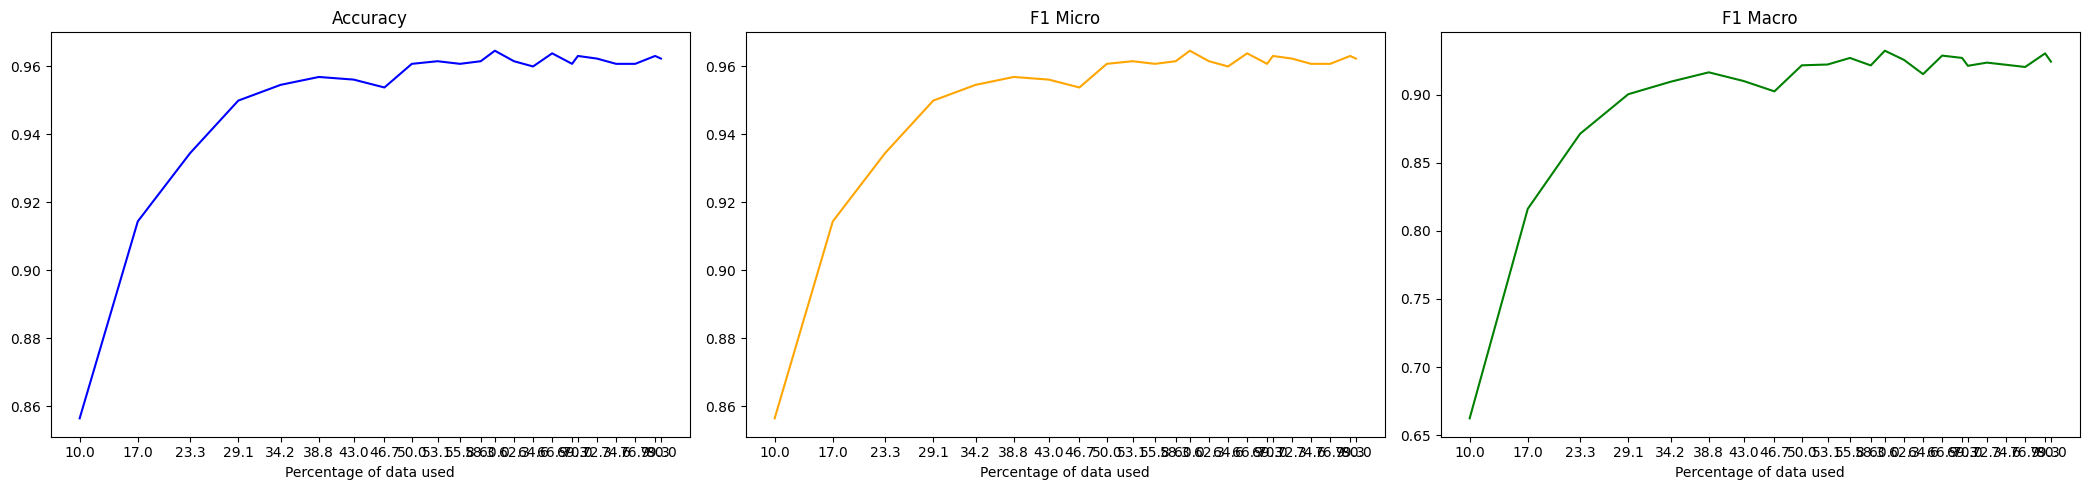

In [23]:
initial_train_size = int(0.1 * total_data)
active_learning(81, 0, 10)